

Here we will figure out what fraction of the solid angle inside the Airy disk is actually summed up in an observation.
It's less than the total solid angle inside the disk, because the response keeps falling off from the center to the
zero crossing.



3831


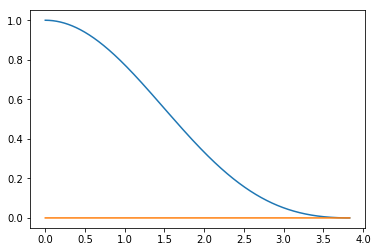

0.22827320604356893


In [17]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

#set up an x axis running from 0.0 to 5.0 (+0.001 to prevent a divide by zero)
x=np.arange(5000)/1000.+1./1000.

#Define the Airy function -- it's (J1(x)/x)**2 where J1 is a Bessel function
airy = (sp.jv(1,x)/x)**2

#Renormalize it to be =1 at the peak:
airy = airy/np.max(airy)

#find where it crosses zero (Airy disk), and limit the range to that point.
#Don't ask me why it has to be w[0][0], that's Python weirdness.
w=np.where(airy == np.min(airy))
print(w[0][0])  ;3831
x=x[0:w[0][0]]
airy = airy[0:w[0][0]]


#show what it looks like:
plt.plot(x,airy)
plt.plot(x,airy*0.)
plt.plot(x,airy*0.+1.0,color=r,)
plt.show()

#Since this is falling off in 2 dimensions, we get solid angle with integral( airy*2pi*r*dr )
#But we want this as a fraction of what it would be if it didn't fall off at all, so we can divide
#this by integral ( 2pi*r*dr ) and the constant factors 2pi*dr cancel out, so simply: 

integralairy = np.sum(  airy*x)
integralnorm = np.sum(x)
print(integralairy/integralnorm)

So this means that we really should be getting only 22.8% of the power we would get if we had 100% response across the whole Airy disk, which has angular radius 1.22(lambda/D) = 1.22(0.21m / 1.8m) = 0.142 radians or 8.16 degrees.  Now since solid angle goes roughly as angular radius squared (for small angles), our integrated response out to the Airy radius is equivalent to the response of a cone that has 100% response out to the edge but has radius:

sqrt(0.228) * 8.16 degrees = 3.90 degrees

So this is the angular radius I will feed into the HEASARC column density tool at 
https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3nh/w3nh.pl
